In [1]:
import numpy as np
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split


In [2]:
def make_dataset(path):
    images=[]
    angry=0
    sad=0
    happy=0
    other=0
    for filename in os.listdir(path):
        new_path=os.path.join(path,filename)
        for img in os.listdir(new_path):
            image=cv2.imread(os.path.join(new_path,img))
            image=cv2.resize(image,(224,224))
            if image is not None:
                if filename=="Angry":
                    images.append(image)
                    angry+=1
                elif filename=="Sad":
                    images.append(image)
                    sad+=1
                elif filename=="happy":
                    images.append(image)
                    happy+=1
    Angry=np.zeros(angry)
    Sad=np.ones(sad)
    Happy=np.repeat(2,happy)
    label=np.hstack((Angry,Sad,Happy))
    label=tf.keras.utils.to_categorical(label,num_classes=3)
    return images,label

In [3]:
images,label=make_dataset("Master Folder")
images=np.array(images)
print(images.shape,label.shape)

(812, 224, 224, 3) (812, 3)


In [4]:
train_X,test_X,train_label,test_label=train_test_split(images,label,test_size=0.2,random_state=42,shuffle=True,stratify=label)

In [5]:
def preprocess_image(images):
    image=tf.cast(images,tf.float32)/255.0
    return image

In [6]:
train_X=preprocess_image(train_X)
test_X=preprocess_image(test_X)

In [35]:
callbacks=[EarlyStopping(monitor = "loss", patience = 10, 
            restore_best_weights = True, mode='min')
            ,ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, mode='min')
            ]

In [76]:
def model_build(inputs):
    
    # feature_extract=tf.keras.applications.mobilenet.MobileNet(input_shape=(224,224,3),weights="imagenet",include_top=False)
    # feature_extract.trainable=False
    # x=feature_extract(inputs,training=False)

    x = tf.keras.layers.Conv2D(64, activation='relu', kernel_size=3, input_shape=(224, 224, 3),padding='same')(inputs)
    x = tf.keras.layers.Conv2D(64,kernel_size=3,activation='relu',padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(128,kernel_size=3,activation='relu',padding='same')(x)
    x = tf.keras.layers.Conv2D(128,kernel_size=3,activation='relu',padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(256,kernel_size=3,activation='relu',padding='same')(x)
    x = tf.keras.layers.Conv2D(256,kernel_size=3,activation='relu',padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(512,kernel_size=3,activation='relu',padding='same')(x)
    x = tf.keras.layers.Conv2D(512,kernel_size=3,activation='relu',padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((4, 4))(x)
    
    x = tf.keras.layers.Conv2D(1024,kernel_size=3,activation='relu',padding='same')(x)
    x=tf.keras.layers.GlobalAveragePooling2D()(x)
    
    x=tf.keras.layers.Dense(64,activation='relu')(x)
    x=tf.keras.layers.Dropout(0.5)(x)
    
    x=tf.keras.layers.Dense(3,activation='softmax')(x)
    
    return x

In [77]:
def define_compile_model():
    inputs=tf.keras.layers.Input(shape=(224,224,3))
    output=model_build(inputs)
    model=tf.keras.Model(inputs=inputs,outputs=output)
    model.compile(optimizer='adamax',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [78]:
model=define_compile_model()
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_40 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_41 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 112, 112, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_42 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_43 (Conv2D)          (None, 112, 112, 128)     147584    
                                                          

In [79]:
epochs=50
batch_size=32
history = model.fit(train_X, train_label,batch_size=batch_size,epochs=epochs,verbose=1,callbacks=callbacks)

Epoch 1/50


KeyboardInterrupt: 

In [67]:
model.evaluate(train_X,train_label)

21/21 [==============================] - 8s 359ms/step - loss: 0.1842 - accuracy: 0.9553


[0.1842396855354309, 0.955315887928009]

In [68]:
model.evaluate(test_X,test_label)

6/6 [==============================] - 2s 270ms/step - loss: 1.1759 - accuracy: 0.5337


[1.175855278968811, 0.5337423086166382]

In [69]:
def detect(path):
    trail_image=cv2.imread(path)
    trail_image=cv2.cvtColor(trail_image,cv2.COLOR_BGR2RGB)
    trail_image=cv2.resize(trail_image,(224,224))
    trail_image=trail_image.reshape(1,224,224,3)
    trail_image_prediction=model.predict(trail_image)
    trail_image_prediction=np.argmax(trail_image_prediction)
    if trail_image_prediction==0:
        prediction="Angry"
    elif trail_image_prediction==1:
        prediction="Sad"
    else:
        prediction="Happy"
    plt.title(prediction)
    plt.imshow(trail_image[0])

1/1 [==============================] - 0s 195ms/step


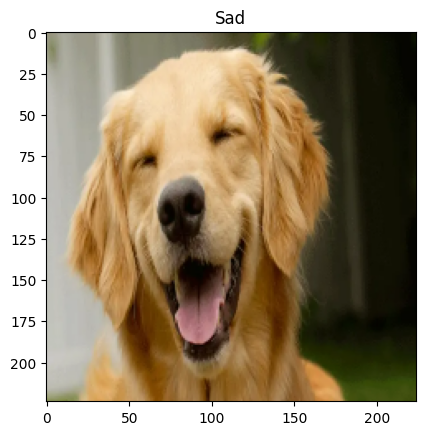

In [70]:
detect("C:\\Users\\Dell\\Downloads\\happy-pup-1.png")

1/1 [==============================] - 0s 47ms/step


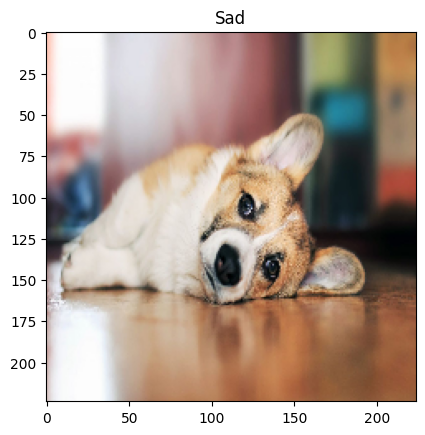

In [71]:
detect("C:\\Users\\Dell\\Downloads\\sad1.jpg")

1/1 [==============================] - 0s 47ms/step


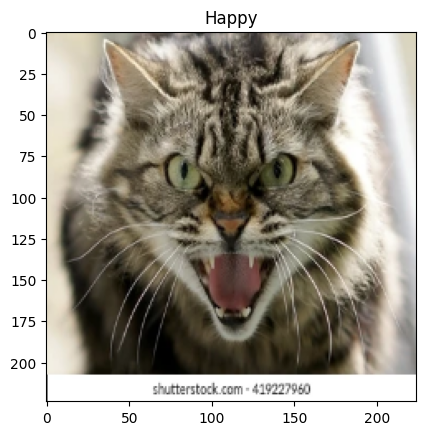

In [72]:
detect("C:\\Users\\Dell\\Downloads\\angry2.webp")